In [1]:
from importlib import reload
def reload_all():
    import tsm; reload(tsm)
    import _keys; reload(_keys)
    import blizzard; reload(blizzard)
    import config; reload(config)
    import kvstore; reload(kvstore)
    import snapshot; reload(snapshot)
    import elemental_arbitrage; reload(elemental_arbitrage)
    import bliz_tsm_join; reload(bliz_tsm_join)
    import crafting; reload(crafting)
    import kvstore; reload(kvstore)
    import crafting; reload(crafting)
    import procurement; reload(procurement)
reload_all()
from itables import show

In [2]:
from snapshot import SnapshotProcessor
from tsm import auction_house_snapshot
from config import tsm_region_id
from config import tsm_realm_id
from config import tsm_ah_id
from config import tsm_cache_dir

def tsm_ah_snapper():
    return auction_house_snapshot(tsm_region_id, tsm_realm_id, tsm_ah_id)

tsm_ah_snap = SnapshotProcessor(tsm_ah_snapper, cache_dir=tsm_cache_dir)
tsm_ah = tsm_ah_snap.get(max_age_seconds=3000)

In [3]:
from snapshot import SnapshotProcessor
from blizzard import auction_data
from blizzard import auction_summary
from config import blizzard_realm_id
from config import blizzard_ah_id
from config import blizzard_cache_dir

def bliz_ah_snapper():
    return auction_data(blizzard_realm_id, blizzard_ah_id)

bliz_ah_snap = SnapshotProcessor(bliz_ah_snapper, cache_dir=blizzard_cache_dir)
bliz_ah = bliz_ah_snap.get(max_age_seconds=3000)

In [4]:
from kvstore import InefficientKVStore
from blizzard import ItemLookup
from blizzard import collapse_languages
from config import blizzard_item_cache
from config import blizzard_item_reverse_cache

items = ItemLookup(
    InefficientKVStore(blizzard_item_cache),
    InefficientKVStore(blizzard_item_reverse_cache),
)

In [5]:
from bliz_tsm_join import item_info_getter
item_info = item_info_getter(items, bliz_ah_snap, tsm_ah_snap, max_age_seconds=3000)
item_info_current = item_info_getter(items, bliz_ah_snap, tsm_ah_snap, max_age_seconds=0)

# TSM Ledger

In [6]:
from cytoolz import groupby
import pandas as pd

df_sales = pd.read_csv("Accounting_Earthfury_sales.csv")
df_sales["mode"] = "sold"
df_purchases = pd.read_csv("Accounting_Earthfury_purchases.csv")
df_purchases["mode"] = "purchased"
df_expired = pd.read_csv("Accounting_Earthfury_expired.csv")
df_expired["mode"] = "expired"
df_canceled = pd.read_csv("Accounting_Earthfury_canceled.csv")
df_canceled["mode"] = "canceled"
df_all = pd.concat([df_sales, df_purchases, df_expired, df_canceled])

entries = list(df_all.transpose().to_dict().values())
grouped = groupby(lambda entry: entry["itemString"], entries)
names = {entry["itemString"]: entry["itemName"] for entry in entries}
nets = {
    k: sum(
        (
            vv["price"]*vv["quantity"] if vv["mode"] == "sold" else
            -vv["price"]*vv["quantity"] if vv["mode"] == "purchased" else
            0
        ) for vv in v
    )
    for (k, v) in grouped.items()
}
ah_events = {k: [vv["mode"] for vv in v if vv["source"] != "Vendor"] for (k, v) in grouped.items()}
sale_rate = {
    k: v.count("sold") / (v.count("sold") + v.count("expired") + v.count("canceled"))
    for (k, v) in ah_events.items()
    if v.count("sold") > 1
}
agg = {k: {"name": names[k], "net": nets[k], "rate": sale_rate[k], "num": len(ah_events[k])} for k in sale_rate}
show(pd.DataFrame(sorted(
    [v for v in agg.values() if v["num"] > 4],
    key=lambda entry: entry["net"],
    reverse=True,
)))

<ipython-input-6-e5b0eba07282>:14: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  entries = list(df_all.transpose().to_dict().values())


# Item Reference

In [78]:
import pickle
from cytoolz import get as pick_from_dict
from cytoolz import sliding_window
import glob
import itertools
from blizzard import auction_summary
import re
import numpy as np
import datetime
np.set_printoptions(suppress=True)

with open("notable_items.txt") as f:
    _names = [line.strip() for line in f]

desired_names = list(set(_names))
desired_ids = [items.get_id(name) for name in desired_names if not name.startswith("#")]


date_re = re.compile(r"202.-..-..T..-..-..")
def _timestamp_from_name(name):
    cap = date_re.search(name).group(0)
    return datetime.datetime.strptime(cap, "%Y-%m-%dT%H-%M-%S").timestamp()


by_item = {}
timeseries = []

for snapshot in sorted(glob.glob("bliz-ah/*")):
    with open(snapshot, "rb") as f:
        entries = pickle.load(f).values()
        timeseries.extend(
            [
                {"timestamp": _timestamp_from_name(snapshot), "item_name": items.get_name(item_id), **auction_summary(item_data)}
                for (item_id, item_data) in zip(desired_ids, entries)
            ]
        )
        for (item_id, item_data) in zip(desired_ids, entries):
            name = items.get_name(item_id)
            by_item[name] = by_item.get(name, []) + [{"timestamp": date_re.search(snapshot).group(0), "item_name": items.get_name(item_id), **auction_summary(item_data)}]

def timeseries_of(key, default=np.nan):
    def _timeseries_of(item_name):
        return np.array([v.get(key, default) for v in by_item[item_name]])
    return _timeseries_of

def omit_outliers(series, sigma=2, window=5):
    mavg = [np.average(w) for w in sliding_window(window, series)]
    std = np.std(mavg)
    return np.array([x if np.abs(x) < sigma*std else np.nan for x in mavg])

def avg_finite(arr):
    return np.average(arr[np.isfinite(arr)])

def min_series(x):
    return omit_outliers(timeseries_of("avg_sell")(x), sigma=0.5, window=10)

## Generate Plots

In [79]:
import plotly.express as px
for yvalue in ["num", "min", "p50", "d_num", "d_min", "d_p50"]:
    df = pd.DataFrame(timeseries)
    df = df.sort_values(by="timestamp")

    if yvalue.startswith("d_"):
        dfg = df.pivot(index="timestamp", columns="item_name", values=yvalue[2:])
        dfg = dfg.diff().div(dfg.index.to_series().diff(), axis=0)
    else:
        dfg = df.pivot(index="timestamp", columns="item_name", values=yvalue)

    fig = px.scatter(dfg, title=yvalue, log_y=False)
    fig.write_html(f"{yvalue}.html")

## Tabular Reference

In [76]:
show(ii := pd.DataFrame([item_info(i) for i in _names]))

# Crafting

In [11]:
from crafting import Recipes
from crafting import purchase_price
from crafting import crafting_price
from crafting import gold


r = Recipes(items)
i = r.ingredients

def buy(item, price_method=gold("realm_market_value")):
    return purchase_price(item_info, item, price_method)


def buy_now(item):
    return buy(item, price_method=gold("min"))


def buy_market(item):
    return buy(item, price_method=gold("realm_market_value"))


with open("recipes.txt") as f:
    recipe_listing = f.read()


r_out = None
for line in recipe_listing.splitlines():
    if line.strip() and not line.strip().startswith("#"):
        if r_out:
            r.recipe_from_strings(r_out, line.strip())
            r_out = None
        else:
            r_out = line.strip()


vendor = {
    "wild spineleaf": 0.45,
    "enchanted vial": 0.90,
    "imbued vial": 0.36,
    "leaded vial": 0.016,
    "weak flux": 0.01,
    "light parchment": 0.01,
}


from procurement import ProcurementPlanner
from procurement import topk_procurements
import procurement
from cytoolz import groupby
from cytoolz import valmap
from cytoolz import topk
pp = ProcurementPlanner(items, item_info, r, vendor, approaches=["ah_buy_now", "craft", "vendor"])
pp_market = ProcurementPlanner(items, item_info, r, vendor, approaches=["ah_buy_market", "craft", "vendor"])


def topn_market(item, n=3):
   return topk(
       n,
       [
           (procurement.cost(x), x) for x in procurement.dnf(pp_market.obtain(item))
       ],
       lambda x: -x[0],
   )

# TukUI Export Strings

In [14]:
# drpannkoeken
"Tukui:Profile:fAvtmTX1w4X2KeGuuaCHONAKIvF8GkAuk2qOrvpfpmyddVIdw2MKIBB6CT9fMjEyUtUZydjTsbHQQER9I(ZoKRu30nvSRRyek77uw0vvkOOSPRAfsvQn9bZ7(ZmdqsKQxyF99(DoNVZ58DpZez4w3cG1av0HwF(UZzyzd01b2AiJbLYGmGks50SQoSz8snQ3ql76MqSg0OkucGtMQq28VSds5EwPCOMW)7qhWoCQQu)roy8YBlTqPslKRWCZkxAZfNlpadnSD7w25gB8VfiFKf7mYxUfzH5amtNbvTHvjaEfO9myWQWYv4oW98U9i7ul9rBXmYyJOoccro4yB8rpD2BwkBbc6lqqReNcs2r7T8OlW50m0wfywEZslKNXicU(KD6u4EmQSJ3r)ycbHOMVkZTZdx2odWgucUUTeA9YT5mz(SZqTlUS4R5DiNnxs46e7eCptz34SJs75nYoEEEYIAp(z0qB2hZL5H2H1MYfcOWaYoZVr37tDLZWE)cXoVNWGx0gWlWLL8J6fRrYRL2pcX5hYXKtRkgLdA0OS7fyPT4vf(erAAloSqFjOXUxgWtwudGEpZOSm35ocri)2H5GNa6PmyaopFqIZUbZG3xrGMxCompcfG7Iusklw3jcV7Q0RWJj5ZZPlMOSB3eGezW6FbR(il2rhVonXDp3X1WJUfVgwFJOjcB2snwEzziOgex2TpE)dNqG3N)NEhswi8Cblzz3E4Yh7VlY(CnxSV)YexB2)js3Pbw20sDqQ2WjcpvRK(VowRf61ubEvu8H)bxg0z0AohRKlOTI6P0pbPCvNouy4Nr4k0f(SiVo4(qCil87qccR7Wyr50)pAfDBol0HyBRYPi6ycSHKfJF4xX8PJ6hDiDXM8AfyLqh1eDucgI525pPiAZdkaBF)YyIF8fyJilEDp(LmN7Ki6Jd1IZIrnmPn6YUJWXT2p4XJzDhHToopkHq62AMtzuvfHdlsX9K4fPmc9q5rlEncOvluZCjHo5AMmBiqR87T4CzXye2)QT7q8uLOu3N1THIXOYI9cUzDkPTJDIZXff31mgJD8BGzGvEjcOXIXUX4K7H)2gHf5BRvJilcIRt90hLMkhDkM2BRxuLDTaHdrZUedO4veIU)X6wKfprsgQWSf8VKONNva3oSMmXyHv53qOtpwyh373fdVXvsfdbCHIp9A(Rm9HSZB69ZekCK)T(PiZBbbX1pDThZ)w)DtZMl6dLlapDv0eDeVh)b78mcfJ1kqqB1KGKm)VM1OkNR10QamOQnepQYzkmBdn9AJQetAwe93EQu8(w2WvhvPlPsARchv5cTchAnQY5pGySn7YISwTAqdfj6gd2kpYsJwBTAwHXPXBI5AQKUJ0)7fP9CwlAudvToSMQ)bPChPImK6PN2z)lfPaPbARo0L4Mprt3PCJtm0n7J63DAIpwQl3mYIl65rNj4kPWt9KjPaPrWvsLIZndZBUzd801(7am5FhGuVaazXp8HmE0)sYoxxqGw0pgFYqUFsh2ffq7qbOv3BwI0eQRzSYWPY3mF3KVY2TzV3gH1RLdygupd7Td90VM0sJklo0t)yIYk6MfH22eRT(g3oU1tcmlRb9vfun7DHk3fsIvtilkqSQ5az0SmjIg(fL8O1GycpuBpvdBubOjqdRUlDDrOU()PHrDv8SqdigOp4U(pjUyvGo8tFf35)jZEVjcVkqxQHTnYOO2dGxRImY(DH3xXSp6qC(bw5H4cO1(hMXj7rUZFQDJTNV1MGQK8iMzFfxtZUQkb6cg8NLQ2UOkWewuvBzBvMJh)0oEtMsKSppSt8CHLUxQtVhM(Ecud2lKpm6lrM(Anyf)6N7nMSnZ1mr5J6VY8OvYbwpZL3Ml9zY2ADvGnqEy3vuEImzhD6UtJ0r43js(Zm2vh7TtgR9IgA8zDwFwB2R(mvdmWsvIoHrDVfn01mQ7)yefYB6uIF828R30hFArAr0Xc8dArTJVSaBBvj6iOjD19J5eJhRnNF08QElwgqx(Tse9H1W753mNgHW1SuoW)VbIrLcmNp52SqZlA)RDNwhyzPvLoqaR0AkQfuXPY))p"
# trowel
"Tukui:Profile:Tz1smTX1A4X2KecPOa4crv3ibQLYfHIsbdHg1wfpmyddn4GLTjT4EB7CSNdmdEyotpZyEKgPyHQQ6AVOp2HCL6MUPID3vmc19DUS4UnOOSPDvfsTQnTW0ZJXJJtIxyF8589)67)7)mtKrQFxawhuYaA)LhUGPTdWWa4OJmhqkfYeQiLr3U8iwXluTsv90BBbX6qZYqjaEIe5sN9fDqcVZlLbTj8lg(e2HZuM6pYbtwCFPLkuyPm5wyE5c7U8czbyOPJxxYU3Q27iq(il2zKVEpYcR(zMohQCv7ca8AqN5WGnGflXDG3L86w2vn5z7XmYSwuxbHiN0YMa0ZM(ofsNJG(Ye0kXPGKD1FdF6cCgDt9nawf3TWszzzebxVYUDk8jSu5a)Z(Fdjie16LzUDr4QoPaoGcWTDKqBxSbptwm9Cu7Ill(V8pLNnxv4Me7e8oxrV4SJs67)VpW33xwu)HpHgAREzUml0jKBkMRzk0VS7I166yQRChX)Nj25)ig88oaobxukiQxrLuxRCCeIZpLJjJEzmkd0SArVlZkBXRlCFrAzloIqVdrJDpmGpnP2e6NyfLv5UFKqeYVDynWtbTnd6NNN3BOZxJzWhOiqRlEoSic1e3vOjPSyf3i8URspcpKuppJUyQIEDrasKbB)vm(rwSJoEvAH7DHwC4z3LZHvQfDOWMTu1vxvgcuH4IE9Y7F4He495xZ)uYcHNjytu0RBU8X5hICmxZf7)oiX1w99uL7SaBhkv3SuR6gHxQLs(xT0AHEnrtVkk(G)Gld6mQQBlLCo910At)0SKl72Hcd)CcxJUiilYAa2bIdZIGoKGW2USSOyY)MYO7ZZcdi2XUycIoMaByzX4N(nmF6Q9XNsxSlNRaRf6OnrNnedXch8Nuen4bfGD2jSR92((jzmU6G(KApkV7opgv1I2IlIjXlqioQS4w)KppMvCf2RvDuaHmC0TMXSSgchssX9L4KukHUP5rDohb0vdJ(vf6KRzsvtGY8hT8cPXyeoy02ByEPsuQhZ62qXyuzXrnNSAtA76m0f4II1TIXYo(eykyPxGaA8ySjg3mp4xRfsYVNUkrw0mUUvsEgJCCZN0FVNxLDJMchIMDfolEnHOh3s3IS5fYeHkmhHGHeJSmcC)qozQXl6nkNLhvOtFwyN0)3edN4kOHHaUqji9wFWF)HmCt4)l1An1pd5(wqZ4guUoJhm1VEs29Ibq5cW2zrl0z8E8)5GNqsXy1BkOT3KGKC)VQ9ykxO(SAamOSdepMY5YnFvDd1XuIjnpI(B3LYVJTdCJXuUOub9nGJPC56HxAnMYLoHySdByrwxvfAQir3yG6zr26uU1E1sSCAYnXCn1eEJ237hPXc2lBQIkxbQQfCqcVrljdPE6XD23krYrAGoAdFvU5tTP3mEXjg6jP4nlHDtrbDrV0YI3NP2f44Ubf3OmCATWfXlDthnDiaYwue0tjGi45as8CEqw8dFGp9MN(wr29Mcm1DlhorRmtRTmB4R2iuEz31UfiuCfDZ1gjr2nZ2f5R0Dz1Z7HWgQzawnzRWo3Wp(BjnSOYId)4pLOBIUBEOJdXA7VZRJ7(OMML2K(IaAw9SuP1HKyTjKffiwZQ)u62wejbFmilAliMKhAnMPQdkh0cOJ1oKUop0W4DRAwrdpp0eIbgdCyWZzZxgya)SxY72)FREUdcVbWqQQJdYmV(9G3OKmY52WDuS6LEfn)a7SqCo0wVIvCYEKj622n2rbwBbktQJyw9MFlDNYAeOlzYFsPwJ8AalyEn9vD0yoEY2D8UmDgzFEyN6zclDVeTVhM(waudokmFyPVe5Uv7bkfWFE3A6gmxZKC)yFLweTwgW2PgCFUWMjkvVyo21TJ4TQYJKj7yq3DwKbc)wrYEUXV(4V5eXASSPo)Mm7pVb7fBMPkgyRjrV)q7OLnn0nRe8qcfY7XuGF8(8Hx6dhTjTi6qp)G6u74lZX2wtIEbZ0EvcI5utgRbp)O1vL6SkGU87Li6d7rokOzolcHvTvoj4VnfJk5yoF69zHMtAV(HZAaST1lth3Xk1NHAbvCQ8pd"

'Tukui:Profile:Tz1smTX1A4X2KecPOa4crv3ibQLYfHIsbdHg1wfpmyddn4GLTjT4EB7CSNdmdEyotpZyEKgPyHQQ6AVOp2HCL6MUPID3vmc19DUS4UnOOSPDvfsTQnTW0ZJXJJtIxyF8589)67)7)mtKrQFxawhuYaA)LhUGPTdWWa4OJmhqkfYeQiLr3U8iwXluTsv90BBbX6qZYqjaEIe5sN9fDqcVZlLbTj8lg(e2HZuM6pYbtwCFPLkuyPm5wyE5c7U8czbyOPJxxYU3Q27iq(il2zKVEpYcR(zMohQCv7ca8AqN5WGnGflXDG3L86w2vn5z7XmYSwuxbHiN0YMa0ZM(ofsNJG(Ye0kXPGKD1FdF6cCgDt9nawf3TWszzzebxVYUDk8jSu5a)Z(Fdjie16LzUDr4QoPaoGcWTDKqBxSbptwm9Cu7Ill(V8pLNnxv4Me7e8oxrV4SJs67)VpW33xwu)HpHgAREzUml0jKBkMRzk0VS7I166yQRChX)Nj25)ig88oaobxukiQxrLuxRCCeIZpLJjJEzmkd0SArVlZkBXRlCFrAzloIqVdrJDpmGpnP2e6NyfLv5UFKqeYVDynWtbTnd6NNN3BOZxJzWhOiqRlEoSic1e3vOjPSyf3i8URspcpKuppJUyQIEDrasKbB)vm(rwSJoEvAH7DHwC4z3LZHvQfDOWMTu1vxvgcuH4IE9Y7F4He495xZ)uYcHNjytu0RBU8X5hICmxZf7)oiX1w99uL7SaBhkv3SuR6gHxQLs(xT0AHEnrtVkk(G)Gld6mQQBlLCo910At)0SKl72Hcd)CcxJUiilYAa2bIdZIGoKGW2USSOyY)MYO7ZZcdi2XUycIoMaByzX4N(nmF6Q9XNsxSlNRaRf6OnrNnedXch8Nuen4bfGD2jSR92((jzmU6G(KApkV7opgv1I2IlIjXlqioQS4w)KppMvCf2RvDuaHmC0TMXSSgchssX9L4KukHUP5rDo

# BIS Filtering from Loon Data

In [124]:
import re
import pandas as pd

loon_path = "C:/Program Files (x86)/World of Warcraft/_classic_/Interface/AddOns/LoonBestInSlot"

item_sources_path = f"{loon_path}/DB/ItemSources.lua"

item_sources_index = {}

item_pickups = []

with open(item_sources_path) as f:
    for entry in f:
        if not entry.strip():
            continue
        try:
            item_id = int(re.search(r"^\s+\[(\d+)\]", entry).group(1))
        except AttributeError:
            continue
        kvs = re.search(r'[A-Z].+ = .*?(?:,| \})', entry).group(0)
        kvs1 = re.sub(r"LBIS.L\[(.*?)\]", r"\1", kvs).replace(r'".."', "")
        kvs2 = re.sub(r"\s+\}$", "", kvs1)
        kvs3 = re.split(r",\s+", kvs2)
        kvs4 = [re.split(r" = ", kv) for kv in kvs3]

        d = {}
        acc = None
        for kv in kvs4:
            # Normal case
            if len(kv) == 2:
                d[kv[0]] = kv[1].strip('"')
            # There was a ' = ' in the name
            elif len(kv) > 2:
                d[kv[0]] = " = ".join(k.strip('"') for k in kv[1:])
            # Hmmmm, shouldn't happen but not harmful if it does
            elif len(kv) == 0:
                continue
            # There was a ', ' in the name; we need to start a join state
            elif len(kv) == 2 and kv[1].count('"') == 1 and kv[1].startswith('"'):
                acc = (kv[0], kv[1].strip('"'))
            # Join state
            elif acc and len(kv) == 1 and kv[0].count('"') == 0:
                acc[1] = acc[1] + ", " + kv[0]
            # End the join state
            elif acc and len(kv) == 1 and kv[0].count('"') == 1:
                acc[1] = acc[1] + ", " + kv[1].strip('"')
                d[acc[0]] = acc[1].strip('"')
                acc = None

        source_split = {k: v.split("/") for (k, v) in d.items() if k != "Name"}

        split_entries = [
            {
                "Id": item_id,
                "Name": d["Name"],
                **dict(zip(source_split.keys(), vs))
            }
            for vs in zip(*list(source_split.values()))
        ]
        item_pickups.extend(split_entries)
        if item_id in item_sources_index:
            item_sources_index[item_id].extend(split_entries)
        else:
            item_sources_index[item_id] = split_entries

            
ranks = [
    "Alt Mit",
    "Alt Stam",
    "Alt Thrt",
    "Alt Transmute",
    "Alt",
    "Alt/BIS",
    "BIS/Alt",
    "BIS Mit",
    "BIS Stam",
    "BIS Thrt",
    "BIS",
]
rank_order = {r: i for (i, r) in enumerate(reversed(ranks))}

def sortable_rank(phase, rank):
    return -int(phase)*len(ranks) + rank_order[rank]

item_guide_path = f"{loon_path}/Guides"
guide_files = glob.glob(f"{item_guide_path}/Phase*/*.lua")

item_guide_index = {}

guide_records = []

for file_ in guide_files:
    print(f"{file_=}")
    with open(file_) as f:
        meta = {}
        for line in f:
            if not line.strip():
                continue
            print(line.strip())
            if "RegisterSpec" in line:
                m = re.search(
                    (
                        r'RegisterSpec\(LBIS.L\["(?P<class>.*?)"\], '
                        r'LBIS.L\["(?P<spec>.*?)"\], '
                        r'"(?P<phase>\d+)"\)'
                    ),
                    line,
                )
                meta = m.groupdict()
            elif meta and line:
                (item_id_str, slot, rank) = [x.strip('"') for x in re.findall(r'".*?"', line)]
                item_id = int(item_id_str)
                record = {
                    "Id": item_id,
                    "Name": items.get_name(item_id),
                    "Slot": slot,
                    "Rank": rank,
                    "Phase": meta["phase"],
                    "Class": meta["class"],
                    "Spec": meta["spec"],
                    "ReadableRank": f"P{meta['phase']} {rank}",
                    "SortableRank": sortable_rank(meta['phase'], rank),
                }
                guide_records.append(record)
                if item_id in item_guide_index:
                    item_guide_index[item_id].append(record)
                else:
                    item_guide_index[item_id] = [record]
            elif line:
                raise ValueError("File metadata did not appear before AddItem entries")


bis_raw = []
for (item_id, records) in item_guide_index.items():
    sources = item_sources_index[item_id]
    for record in records:
        for source in sources:
            bis_raw.append({**record, **source})


bis = pd.DataFrame(bis_raw)

file_='C:/Program Files (x86)/World of Warcraft/_classic_/Interface/AddOns/LoonBestInSlot/Guides\\Phase0\\DeathKnightBlood.lua'
local spec = LBIS:RegisterSpec(LBIS.L["Death Knight"], LBIS.L["Blood"], "0")
LBIS:AddItem(spec, "39625", LBIS.L["Head"], "BIS") --Heroes' Scourgeborne Faceguard
LBIS:AddItem(spec, "40618", LBIS.L["Head"], "BIS") --Helm of the Lost Vanquisher
LBIS:AddItem(spec, "39627", LBIS.L["Shoulder"], "BIS") --Heroes' Scourgeborne Pauldrons
LBIS:AddItem(spec, "40624", LBIS.L["Shoulder"], "BIS") --Spaulders of the Lost Vanquisher
LBIS:AddItem(spec, "43988", LBIS.L["Back"], "BIS") --Gale-Proof Cloak
LBIS:AddItem(spec, "39398", LBIS.L["Chest"], "BIS") --Massive Skeletal Ribcage
LBIS:AddItem(spec, "40734", LBIS.L["Wrist"], "BIS") --Bracers of Dalaran's Parapets
LBIS:AddItem(spec, "39624", LBIS.L["Hands"], "BIS") --Heroes' Scourgeborne Handguards
LBIS:AddItem(spec, "40615", LBIS.L["Hands"], "BIS") --Gloves of the Lost Vanquisher
LBIS:AddItem(spec, "40689", LBIS.L["Waist"], "BIS

In [131]:
import itertools
from functools import partial
from functools import reduce


def bis_filter(k1, k2):
    return bis[k1] == k2


def bis_or(entries):
    entries = iter(entries)
    start = next(entries)
    return reduce(lambda acc, x: acc | x, entries, start)


bfspec = partial(bis_filter, "Spec")
bfloc = partial(bis_filter, "SourceLocation")
bfsrc = partial(bis_filter, "Source")
bfrank = partial(bis_filter, "Rank")
bfrerank = partial(bis_filter, "ReadableRank")
bfphase = partial(bis_filter, "Phase")
bfslot = partial(bis_filter, "Slot")
bftype = partial(bis_filter, "SourceType")


def raidnames(name):
    return [f"{name}", f"{name} (10)", f"{name} (25)"]


def without_columns(columns, df):
    return reduce(lambda acc, x: acc.drop(x, axis=1), columns, df)


raids_ = [
    "Naxxramas",
    "The Obsidian Sanctum",
    "The Eye of Eternity",
    "Vault of Archavon",
    "Ulduar",
]

raids = list(itertools.chain.from_iterable(raidnames(n) for n in raids_))


def bis_display(filters, drop_columns=None, show_args=None):
    drop_columns = drop_columns or []
    show_args = show_args or {}
    return show(without_columns(drop_columns, bis[filters]), **show_args)

## Heroic Drops

In [149]:
bis_display(
    (
        bfspec("Balance") &
        ~bis_or(bfloc(x) for x in raids) &
        bftype("Drop") &
        bis_or(bfrerank(x) for x in ["P1 Alt", "P1 BIS", "P2 Alt", "P2 BIS"])
    ),
    drop_columns=["Id", "SourceNumber", "SourceType", "Class", "Spec", "Phase", "Rank"],
    show_args={"lengthMenu": [25], "order": [[4, "asc"]]},
)

## Non-Ulduar Drops

In [147]:
bis_display(
    (
        bfspec("Balance") &
        ~bis_or(bfloc(x) for x in raidnames("Ulduar")) &
        bftype("Drop") &
        bis_or(bfrerank(x) for x in ["P1 Alt", "P1 BIS", "P2 Alt", "P2 BIS"])
    ),
    drop_columns=["Id", "SourceNumber", "SourceType", "Class", "Spec", "Phase", "Rank"],
    show_args={"lengthMenu": [20, 10, 50, 9999], "order": [[4, "asc"]]},
)

## Ulduar Drops

In [148]:
bis_display(
    (
        bfspec("Balance") &
        bftype("Drop") &
        bis_or(bfrerank(x) for x in ["P1 Alt", "P1 BIS", "P2 Alt", "P2 BIS"]) &
        bis_or(bfloc(x) for x in raidnames("Ulduar"))
    ),
    drop_columns=["Id", "SourceNumber", "SourceType", "Class", "Spec", "Phase", "Rank",],
    show_args={"lengthMenu": [20, 10, 30, 50, 100], "order": [[4, "asc"]]},
)

# Fishing for 10 minutes

**Vengeance Landing - from shore**

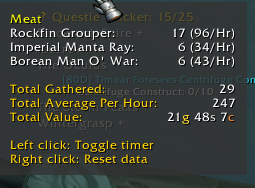

**Vengeance Landing - from boat**

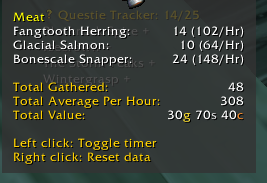

**Wintergrasp**

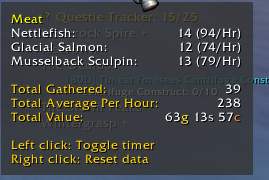

**Grizzly Hills (West to East along river, pools only)**

(also about 30 pygmy suckerfish)

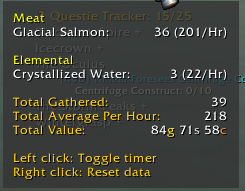
